<div class="alert alert-success">
<b>Reviewer's comment V2</b>
  
Thanks for taking the time to improve the project! It is accepted now. Keep up the good work on the next sprint! :)
  
</div>

**Review**
  
Hi, my name is Dmitry and I will be reviewing your project.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! You did a great job overall! There's only one small problem that needs to be fixed before I can accept the project. I also left a couple of suggestions for improvements. Good luck!

# Supervised learning project

#### Beta Bank customers are leaving. The bankers figured out it’s cheaper to save the existing customers rather than to attract new ones.
This study aimes to predict weather a client will leave or not, according to given data comrised of information on Customer_ID, Surname, Credit_Score, Geographyical location, Gender, Tenure, acount balance, number of products, credit card ownership, activity level and estimated salary.

In [1]:
!pip install -q --user --upgrade pandas matplotlib seaborn sklearn scikit-learn

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate 
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, mean_squared_error, roc_auc_score, roc_curve 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings("ignore")

##  Data preparation

In [3]:
try:
    df= pd.read_csv('Churn.csv')
except:
    df=pd.read_csv('/datasets/Churn.csv')

In [4]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was loaded and inspected

</div>

- before any steps of preprocessing can be taken we must first set side the test data to simulate a truely unseen new data. we will set aside 25% of the data as 'test' and the remaining 75% will be used for training and validation:

In [5]:
X=df.drop('Exited', axis=1)
y=df['Exited']

In [6]:
X_data, X_test, y_data, y_test= train_test_split(X,y, test_size=0.25, random_state=42)

<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was split into train and test. The proportions are reasonable

</div>

- now we can take a look at the X_data desigbed for training and validation, and process it:
    - columns 'RowNumber', 'CustomerId' and 'Surname' are redundant for the purposes of model performance and so can be removed.
    - numeric columns will be scaled and normalized.
    - categorical columns will be One-Hot-Encoded.
    - Nan values will be filled if their percentage is greater than 1%.
    - duplicate entries will be removed.

In [7]:
X_data= X_data.drop(columns=['RowNumber', 'CustomerId', 'Surname'], axis=1)

<div class="alert alert-success">
<b>Reviewer's comment</b>

Yeah, these columns indeed don't seem to have any plausible influence on our target variable.

</div>

In [8]:
X_data.duplicated().sum()

0

In [9]:
X_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7500 entries, 4901 to 7270
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      7500 non-null   int64  
 1   Geography        7500 non-null   object 
 2   Gender           7500 non-null   object 
 3   Age              7500 non-null   int64  
 4   Tenure           6823 non-null   float64
 5   Balance          7500 non-null   float64
 6   NumOfProducts    7500 non-null   int64  
 7   HasCrCard        7500 non-null   int64  
 8   IsActiveMember   7500 non-null   int64  
 9   EstimatedSalary  7500 non-null   float64
dtypes: float64(3), int64(5), object(2)
memory usage: 644.5+ KB


- as can be seen, the 'Tenure' column is the only one with missing values. let's take a closer look at possible correlations between Tenure and other features which may enable us to find optional ways to fill the relevant NaN values:

In [10]:
X_data.groupby('Tenure')['Age'].median()

Tenure
0.0     38.0
1.0     37.0
2.0     37.0
3.0     37.0
4.0     36.0
5.0     38.0
6.0     37.0
7.0     37.0
8.0     36.0
9.0     38.0
10.0    38.0
Name: Age, dtype: float64

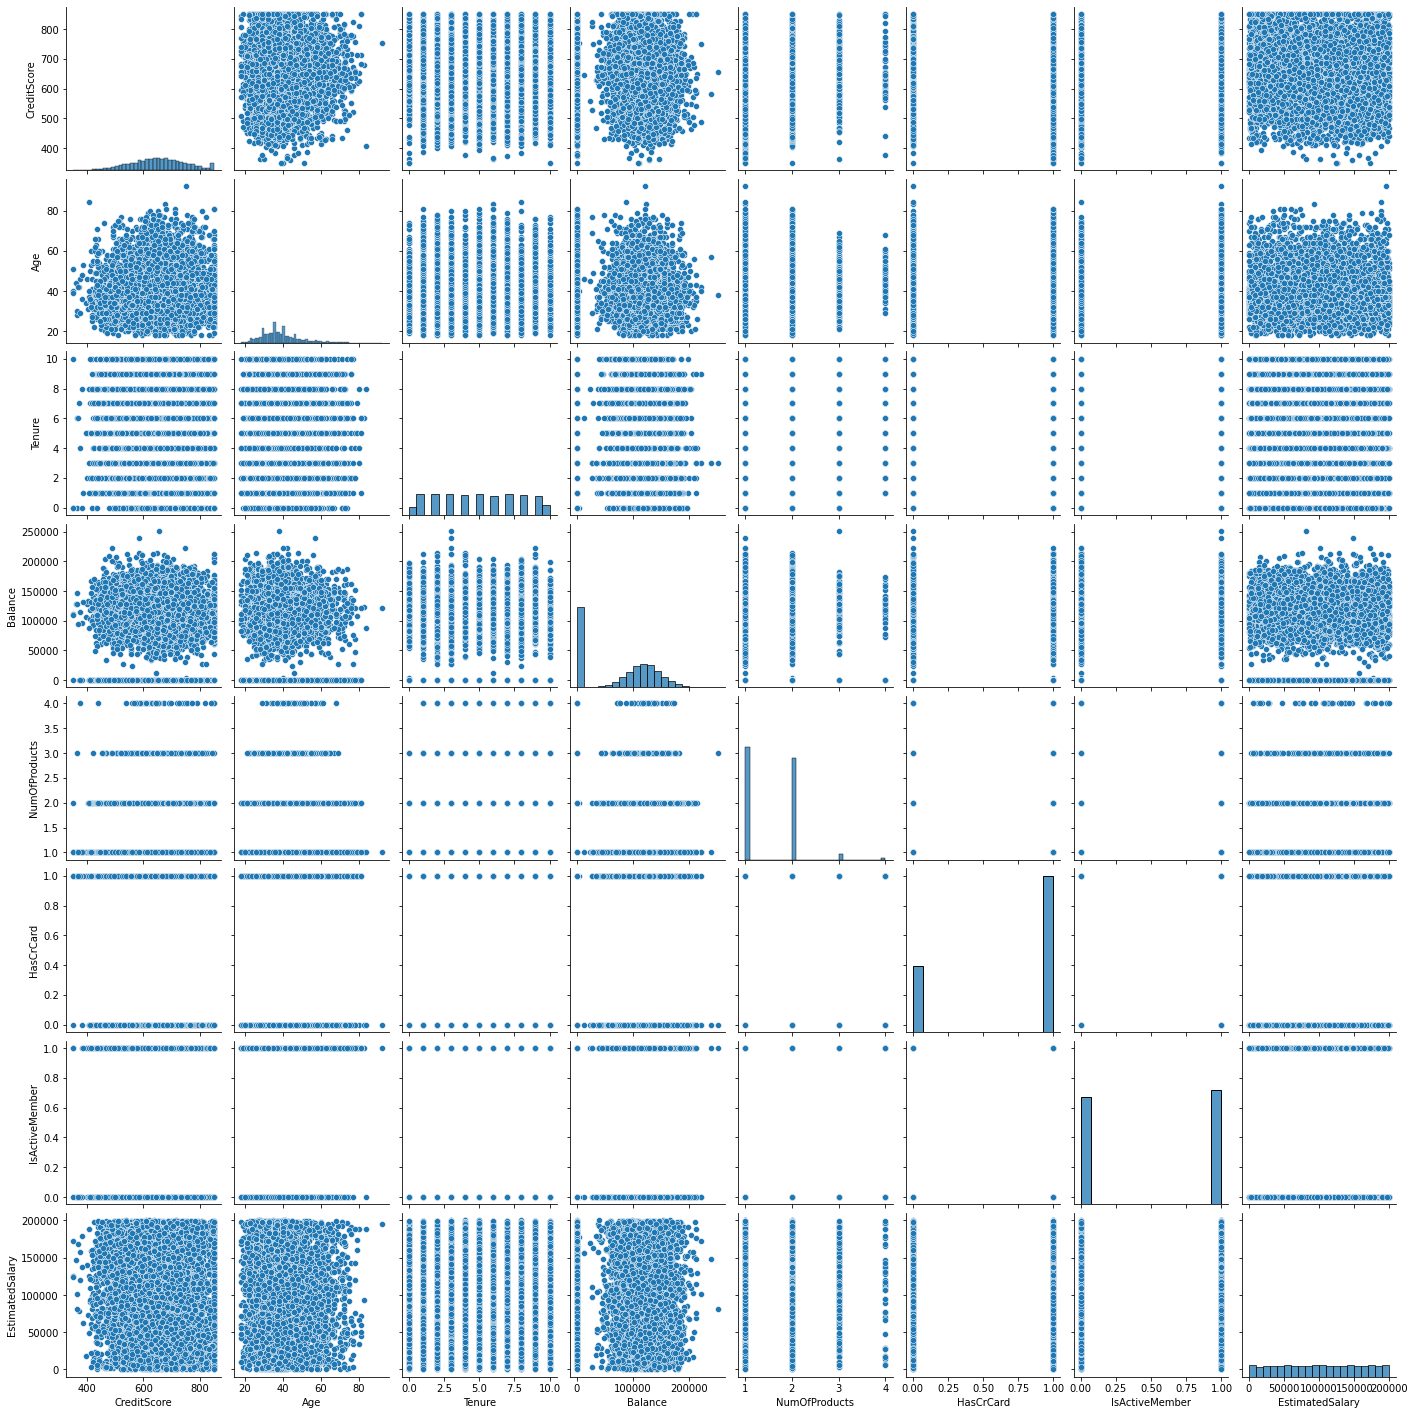

In [11]:
sns.pairplot(X_data)
plt.show()

- considering the correlations presented in the pairplot, we can see that there's no distinguished correlation between the Tenurte feature and the other features. (and in general there are no significant correlations between the features)

<div class="alert alert-success">
<b>Reviewer's comment</b>

Pair plot is a great way to get a sense of how each pair of features are related

</div>

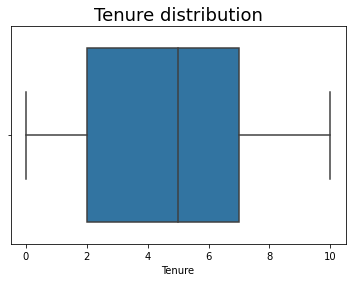

In [12]:
sns.boxplot(x=X_data.Tenure).set_title('Tenure distribution', fontsize=18)
plt.show()

- as the median value of the Tenure feature is 5, will we use it to fill the missing values:

In [13]:
X_data['Tenure']= X_data['Tenure'].fillna(5)

<div class="alert alert-warning">
<b>Reviewer's comment</b>

Ok, that's a reasonable to deal with missing values, but it seems that there is a better explanation of why the feature is missing: as tenure represents how long someone has been a client, maybe missing values correspond to new clients?

</div>

<div class="alert alert-info">
  Good idea! :)
</div>

In [14]:
X_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7500 entries, 4901 to 7270
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      7500 non-null   int64  
 1   Geography        7500 non-null   object 
 2   Gender           7500 non-null   object 
 3   Age              7500 non-null   int64  
 4   Tenure           7500 non-null   float64
 5   Balance          7500 non-null   float64
 6   NumOfProducts    7500 non-null   int64  
 7   HasCrCard        7500 non-null   int64  
 8   IsActiveMember   7500 non-null   int64  
 9   EstimatedSalary  7500 non-null   float64
dtypes: float64(3), int64(5), object(2)
memory usage: 902.6+ KB


- feature transformation: OHE and scaling:

In [15]:
X_data= pd.get_dummies(X_data, drop_first=True, prefix=['Geography', 'Gender'])
X_data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
4901,673,59,0.0,178058.06,2,0,1,21063.71,0,0,1
4375,850,41,5.0,60880.68,1,1,0,31825.84,1,0,1
6698,725,31,6.0,0.00,1,0,0,61326.43,0,0,0
9805,644,33,7.0,174571.36,1,0,1,43943.09,0,0,1
1101,703,29,9.0,0.00,2,1,0,50679.48,0,1,1


<div class="alert alert-warning">
<b>Reviewer's comment</b>

In this case `pd.get_dummies` seems to work fine, but in general you're better off using [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), which is first trained on the train set, and then transforms both the train set and the test set to make sure that there is no discrepancy in column order, etc.

</div>

In [16]:
scaler = StandardScaler()
numeric= ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [17]:
X_data[numeric]= scaler.fit_transform(X_data[numeric])
X_data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
4901,0.218351,1.916619,-1.810458,1.629928,0.813111,0,1,-1.382844,0,0,1
4375,2.057280,0.202109,0.007320,-0.246244,-0.911043,1,0,-1.195890,1,0,1
6698,0.758602,-0.750397,0.370875,-1.221027,-0.911043,0,0,-0.683422,0,0,0
9805,-0.082942,-0.559895,0.734431,1.574101,-0.911043,0,1,-0.985396,0,0,1
1101,0.530034,-0.940898,1.461542,-1.221027,0.813111,1,0,-0.868375,0,1,1


<div class="alert alert-success">
<b>Reviewer's comment</b>

Great, scaling is applied correctly!

</div>

- the data is now preprocessed and can be used for training and validation.

In [18]:
print(X_data.shape)
print(y_data.shape)
print(X_test.shape)
print(y_test.shape)

(7500, 11)
(7500,)
(2500, 13)
(2500,)


## Model training and selection- disregarding class imbalance

- assesment of class imbalance:

In [19]:
class_1_percentage =(y_data.mean()*100).round(2)
print('class 1 percentage:', class_1_percentage)
print('class 0 percentage:', 100-class_1_percentage)

class 1 percentage: 20.53
class 0 percentage: 79.47


- as can be see, the classes are imbalanced with class 0 being about 4 times more common.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Class imbalance was noted!

</div>

#### using HalvingGridsearchCV to find the optimal model among 4 options: 
    1) Decision tree classifier 
    2) Random forest classifier 
    3) Logistic regression classifier 
    4) KNeighbors classifier

1) Desicion Tree Classifier

In [20]:
model= DecisionTreeClassifier(random_state=42)
param_grid_dt= {'criterion':['gini', 'entropy'], 'max_depth':[1, 2, 3, 4, 5, 6], 'min_samples_leaf':[1,2,3,4,5,6]}

In [21]:
dt_classifier= HalvingGridSearchCV(model, param_grid=param_grid_dt, scoring='f1', random_state=1).fit(X_data, y_data)
dt_classifier

HalvingGridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                    param_grid={'criterion': ['gini', 'entropy'],
                                'max_depth': [1, 2, 3, 4, 5, 6],
                                'min_samples_leaf': [1, 2, 3, 4, 5, 6]},
                    random_state=1, scoring='f1')

In [22]:
print('The best parameters found for Decision tree classifier:', dt_classifier.best_params_)
print('The best f1 score obtained for this model:', dt_classifier.best_score_.round(3))

The best parameters found for Decision tree classifier: {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 1}
The best f1 score obtained for this model: 0.553


In [23]:
dt_optimal= DecisionTreeClassifier(random_state=42, criterion='gini', max_depth=6, min_samples_leaf=1)
print('roc-auc score for dt_optimal:', (cross_val_score(dt_optimal, X_data, y_data, cv=5, scoring='roc_auc').mean()).round(3))

roc-auc score for dt_optimal: 0.834


2) Random Forest Classifier

In [24]:
model= RandomForestClassifier(random_state=42)
n_estimators= [100, 150, 200]
criterion= ['gini', 'entropy']
max_depth= [2, 4, 6]

param_grid_rf= dict(n_estimators= n_estimators, criterion=criterion, max_depth=max_depth)

In [25]:
rf_classifier= HalvingGridSearchCV(model, param_grid=param_grid_rf, scoring= 'f1', random_state=1).fit(X_data, y_data)
rf_classifier

HalvingGridSearchCV(estimator=RandomForestClassifier(random_state=42),
                    param_grid={'criterion': ['gini', 'entropy'],
                                'max_depth': [2, 4, 6],
                                'n_estimators': [100, 150, 200]},
                    random_state=1, scoring='f1')

In [26]:
print('The best parameters found for Random Forest tree classifier:', rf_classifier.best_params_)
print('The best f1 score obtained for this model:', rf_classifier.best_score_.round(3))

The best parameters found for Random Forest tree classifier: {'criterion': 'gini', 'max_depth': 6, 'n_estimators': 200}
The best f1 score obtained for this model: 0.503


In [27]:
rf_optimal= RandomForestClassifier(random_state=42, n_estimators=200, criterion='gini', max_depth=6)
print('roc-auc score for rf_optimal:', (cross_val_score(rf_optimal, X_data, y_data, cv=5, scoring='roc_auc').mean()).round(3))

roc-auc score for rf_optimal: 0.855


3) Logistic Regression

In [28]:
model= LogisticRegression(random_state=42)
solver= ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
param_grid_lr= dict(solver=solver)

In [29]:
lr_classifier= HalvingGridSearchCV(model, param_grid=param_grid_lr, scoring= 'f1', random_state=1).fit(X_data, y_data)
lr_classifier

HalvingGridSearchCV(estimator=LogisticRegression(random_state=42),
                    param_grid={'solver': ['newton-cg', 'lbfgs', 'liblinear',
                                           'sag', 'saga']},
                    random_state=1, scoring='f1')

In [30]:
print('The best parameters found for Logistic Regression classifier:', lr_classifier.best_params_)
print('The best f1 score obtained for this model:', lr_classifier.best_score_.round(3))

The best parameters found for Logistic Regression classifier: {'solver': 'saga'}
The best f1 score obtained for this model: 0.319


In [31]:
lr_optimal= LogisticRegression(random_state=42, solver= 'saga')
print('roc-auc score for lr_optimal:', (cross_val_score(lr_optimal, X_data, y_data, cv=5, scoring='roc_auc').mean()).round(3))

roc-auc score for lr_optimal: 0.762


4) KNeighbors

In [32]:
model= KNeighborsClassifier()
n_neighbors= list(range(1, 31))
weights= ['uniform', 'distance']
param_grid_kn= dict(n_neighbors= n_neighbors, weights= weights)

In [33]:
kn_classifier= HalvingGridSearchCV(model, param_grid=param_grid_kn, scoring= 'f1', random_state=1).fit(X_data, y_data)
kn_classifier

HalvingGridSearchCV(estimator=KNeighborsClassifier(),
                    param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                11, 12, 13, 14, 15, 16, 17, 18,
                                                19, 20, 21, 22, 23, 24, 25, 26,
                                                27, 28, 29, 30],
                                'weights': ['uniform', 'distance']},
                    random_state=1, scoring='f1')

In [34]:
print('The best parameters found for K Neighbors classifier:', kn_classifier.best_params_)
print('The best f1 score obtained for this model:', kn_classifier.best_score_.round(3))

The best parameters found for K Neighbors classifier: {'n_neighbors': 8, 'weights': 'distance'}
The best f1 score obtained for this model: 0.524


In [35]:
kn_optimal= KNeighborsClassifier(n_neighbors=8 , weights='distance')
print('roc-auc score for kn_optimal:', (cross_val_score(kn_optimal, X_data, y_data, cv=5, scoring='roc_auc').mean()).round(3))

roc-auc score for kn_optimal: 0.812


- as can be seen, non of the attempted models have yielded a F1 score greater than 0.59. this is probably due to the fact that we neglected to rectify the class imbalance in the set, which introduced class bias to the models. However the models do a fair job at discrimination between true possitives and false positives, according to the relatively high auc-roc scores.  let's correct the class imbalance and make the assesments again:

<div class="alert alert-success">
<b>Reviewer's comment</b>

Great, you tried a couple of different models and did some hyperparameter tuning with proper cross-validation. It's great that you used F1 for the scoring function!

</div>

## Fixing Class imbalance and retraining

#### using the 'Class_weight' parameters in DecisionTree, RandomForest and LogisticRegression

1) Decision Tree classifier- with class_weight= 'balanced':

In [36]:
dt_classifier_balanced= DecisionTreeClassifier(random_state=42, criterion='gini', max_depth=6, min_samples_leaf=1, class_weight='balanced')

In [37]:
print('The f1 score for Decision Tree classifier using balanced class weight:', cross_val_score(dt_classifier_balanced, X_data, y_data, cv=5, scoring='f1').mean().round(3))
print('The auc-roc score for Decision Tree classifier using balanced class weight:', cross_val_score(dt_classifier_balanced, X_data, y_data, cv=5, scoring='roc_auc').mean().round(3))

The f1 score for Decision Tree classifier using balanced class weight: 0.562
The auc-roc score for Decision Tree classifier using balanced class weight: 0.83


0.562 is an improvement to the previous score of 0.550, but still not high enough for our purpose. the auc-roc score hasn't changed significantly.

2) Random Forest classifier- with class_weight= 'balanced':

In [38]:
rf_classifier_balanced= RandomForestClassifier(random_state=42, n_estimators=200, criterion='gini', max_depth=6, class_weight='balanced')

In [39]:
print('The f1 score for Random Forest classifier using balanced class weight:', cross_val_score(rf_classifier_balanced, X_data, y_data, cv=5, scoring='f1').mean().round(3))
print('The auc-roc score for Random Forest classifier using balanced class weight:', cross_val_score(rf_classifier_balanced, X_data, y_data, cv=5, scoring='roc_auc').mean().round(3))

The f1 score for Random Forest classifier using balanced class weight: 0.597
The auc-roc score for Random Forest classifier using balanced class weight: 0.856


0.598 is an improvement to the previous score of 0.495 and is even high enough to meet our requirements. the auc-roc score hasn't changed significantly.

Logistic Regression classifier- with class_weight= 'balanced':

In [40]:
lr_classifier_balanced= LogisticRegression(random_state=42, solver= 'saga', class_weight= 'balanced')

In [41]:
print('The f1 score for Logistic Regression classifier using balanced class weight:', cross_val_score(lr_classifier_balanced, X_data, y_data, cv=5, scoring='f1').mean().round(3))
print('The auc-roc score for Logistic Regression classifier using balanced class weight:', cross_val_score(lr_classifier_balanced, X_data, y_data, cv=5, scoring='roc_auc').mean().round(3))

The f1 score for Logistic Regression classifier using balanced class weight: 0.494
The auc-roc score for Logistic Regression classifier using balanced class weight: 0.765


0.494 is a dramatic improvement to 0.319, but still fails to meet our requierments. the auc-roc score hasn't changed significantely.

#### using the 'upsampling' technique to rectify class imbalance:

- splitting the data into possitive and negative:

In [42]:
X_zeros= X_data[y_data==0]
X_ones= X_data[y_data==1]
y_zeros= y_data[y_data==0]
y_ones= y_data[y_data==1]

In [43]:
X_upsampled= pd.concat([X_zeros] + [X_ones]*4 )
y_upsampled= pd.concat([y_zeros] + [y_ones]*4)
print(X_upsampled.shape)
print(y_upsampled.shape)

(12120, 11)
(12120,)


- shuffling the upsampled data:

In [44]:
X_upsampled, y_upsampled= shuffle(X_upsampled, y_upsampled, random_state=42)

let's use the optimal hyperparameters selected in the HalvingGridsearchCV found in section 2:

1) Decision Tree classifier- upsampled data

In [45]:
model= DecisionTreeClassifier(random_state=42)
param_grid_dt= {'criterion':['gini', 'entropy'], 'max_depth':[1, 2, 3, 4, 5, 6], 'min_samples_leaf':[1,2,3,4,5,6]}

In [46]:
dt_classifier= HalvingGridSearchCV(model, param_grid=param_grid_dt, scoring= 'f1', random_state=1).fit(X_upsampled, y_upsampled)

In [47]:
print('The best parameters found for Decision tree classifier:', dt_classifier.best_params_)
print('The best f1 score obtained for this model:', dt_classifier.best_score_.round(3))

The best parameters found for Decision tree classifier: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 2}
The best f1 score obtained for this model: 0.789


In [48]:
dt_optimal= DecisionTreeClassifier(random_state= 42, criterion= 'entropy', max_depth= 6, min_samples_leaf= 2)
print('roc-auc score for dt_optimal:', (cross_val_score(dt_optimal, X_upsampled, y_upsampled, cv=5, scoring='roc_auc').mean()).round(3))

roc-auc score for dt_optimal: 0.86


f1 score of 0.789 is far greater than 0.562, which is the f1 score we obtained using the class_weight= 'balance' hyperparameter. the auc-roc score hasn't changed significantly.

2) Random Forest classifier- upsampled data

In [49]:
model= RandomForestClassifier(random_state=42)
n_estimators= [100, 150, 200]
criterion= ['gini', 'entropy']
max_depth= [2, 4, 6]
param_grid_rf= dict(n_estimators= n_estimators, criterion=criterion, max_depth=max_depth)

In [50]:
rf_classifier= HalvingGridSearchCV(model, param_grid=param_grid_rf, scoring= 'f1', random_state=1).fit(X_upsampled, y_upsampled)

In [51]:
print('The best parameters found for Random Forest tree classifier:', rf_classifier.best_params_)
print('The best f1 score obtained for this model:', rf_classifier.best_score_.round(3))

The best parameters found for Random Forest tree classifier: {'criterion': 'gini', 'max_depth': 6, 'n_estimators': 150}
The best f1 score obtained for this model: 0.786


In [52]:
rf_optimal= RandomForestClassifier(random_state=42, n_estimators=150, criterion='gini', max_depth=6)
print('roc-auc score for rf_optimal:', (cross_val_score(rf_optimal, X_upsampled, y_upsampled, cv=5, scoring='roc_auc').mean()).round(3))

roc-auc score for rf_optimal: 0.873


f1 score of 0.786 is far greater than 0.599, which is the f1 score we obtained using the class_weight= 'balance' hyperparameter. the auc-roc score hasn't changed significantly.

3) Logistic Regression- upsampled data

In [53]:
model= LogisticRegression(random_state=42)
solver= ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
param_grid_lr= dict(solver=solver)

In [54]:
lr_classifier= HalvingGridSearchCV(model, param_grid=param_grid_lr, scoring= 'f1', random_state=1).fit(X_upsampled, y_upsampled)

In [55]:
print('The best parameters found for Logistic Regression classifier:', lr_classifier.best_params_)
print('The best f1 score obtained for this model:', lr_classifier.best_score_.round(3))

The best parameters found for Logistic Regression classifier: {'solver': 'sag'}
The best f1 score obtained for this model: 0.706


In [56]:
lr_optimal= LogisticRegression(random_state=42, solver= 'saga')
print('roc-auc score for lr_optimal:', (cross_val_score(lr_optimal, X_upsampled, y_upsampled, cv=5, scoring='roc_auc').mean()).round(3))

roc-auc score for lr_optimal: 0.768


f1 score of 0.706 is far greater than 0.494, which is the f1 score we obtained using the class_weight= 'balance' hyperparameter. the auc-roc score hasn't changed significantly.

4) KNeighbors classifier- upsamples data

In [57]:
model= KNeighborsClassifier()
n_neighbors= list(range(1, 31))
weights= ['uniform', 'distance']
param_grid_kn= dict(n_neighbors= n_neighbors, weights= weights)

In [58]:
kn_classifier= HalvingGridSearchCV(model, param_grid=param_grid_kn, scoring= 'f1', random_state=1).fit(X_upsampled, y_upsampled)

In [59]:
print('The best parameters found for K Neighbors classifier:', kn_classifier.best_params_)
print('The best f1 score obtained for this model:', kn_classifier.best_score_.round(3))

The best parameters found for K Neighbors classifier: {'n_neighbors': 22, 'weights': 'distance'}
The best f1 score obtained for this model: 0.899


In [60]:
kn_optimal= KNeighborsClassifier(n_neighbors= 22 , weights= 'distance')
print('roc-auc score for kn_optimal:', (cross_val_score(kn_optimal, X_upsampled, y_upsampled, cv=5, scoring='roc_auc').mean()).round(3))

roc-auc score for kn_optimal: 0.998


f1 score of 0.899 is far greater than 0.524, which is the f1 score we obtained without adressing the class imbalance issue. auc-roc inceased significantly.

#### Conclusion: we have seen that f1 scores improved consistantly throughout the various different models attempted, which indicates the significant weight balanced data has over model performance. the best model selected would be KNeighbors classifier with the highset f1 score of 0.896.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Very good, you tried three different methods of dealing with class imbalance, each one was applied correctly.

</div>

## Testing the selected model using the test set

before we can test the model on the test set, we need to precess it using the same processing we previously performed on the training set:

In [61]:
X_test.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
6252,6253,15687492,Anderson,596,Germany,Male,32,3.0,96709.07,2,0,0,41788.37
4684,4685,15736963,Herring,623,France,Male,43,1.0,0.00,2,1,1,146379.30
1731,1732,15721730,Amechi,601,Spain,Female,44,4.0,0.00,2,1,0,58561.31
4742,4743,15762134,Liang,506,Germany,Male,59,8.0,119152.10,2,1,1,170679.74
4521,4522,15648898,Chuang,560,Spain,Female,27,7.0,124995.98,1,1,1,114669.79


In [62]:
X_test= X_test.drop(columns=['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [63]:
X_test.duplicated().sum()

0

In [64]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 6252 to 73
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      2500 non-null   int64  
 1   Geography        2500 non-null   object 
 2   Gender           2500 non-null   object 
 3   Age              2500 non-null   int64  
 4   Tenure           2268 non-null   float64
 5   Balance          2500 non-null   float64
 6   NumOfProducts    2500 non-null   int64  
 7   HasCrCard        2500 non-null   int64  
 8   IsActiveMember   2500 non-null   int64  
 9   EstimatedSalary  2500 non-null   float64
dtypes: float64(3), int64(5), object(2)
memory usage: 214.8+ KB


In [65]:
X_test= pd.get_dummies(X_test, drop_first=True, prefix=['Geography', 'Gender'])
X_test.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
6252,596,32,3.0,96709.07,2,0,0,41788.37,1,0,1
4684,623,43,1.0,0.00,2,1,1,146379.30,0,0,1
1731,601,44,4.0,0.00,2,1,0,58561.31,0,1,0
4742,506,59,8.0,119152.10,2,1,1,170679.74,1,0,1
4521,560,27,7.0,124995.98,1,1,1,114669.79,0,1,0


In [66]:
X_test.Tenure.median()

5.0

In [67]:
X_test['Tenure']= X_test['Tenure'].fillna(5)

In [68]:
X_test[numeric]= scaler.transform(X_test[numeric])
X_test.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
6252,-0.581635,-0.655146,-0.719792,0.327418,0.813111,0,0,-1.022827,1,0,1
4684,-0.301120,0.392610,-1.446903,-1.221027,0.813111,1,1,0.794069,0,0,1
1731,-0.529688,0.487861,-0.356236,-1.221027,0.813111,1,0,-0.731457,0,1,0
4742,-1.516684,1.916619,1.097986,0.686762,0.813111,1,1,1.216203,1,0,1
4521,-0.955654,-1.131399,0.734431,0.780331,-0.911043,1,1,0.243229,0,1,0


In [69]:
print(X_test.shape)
print(y_test.shape)

(2500, 11)
(2500,)


<div class="alert alert-success">
<b>Reviewer's comment</b>

The test set was preprocessed the same way as the train set.

</div>

#### Predicting f1 and roc_auc scores for test set:

KNeighbors classifier:

In [70]:
y_predicted_kn= kn_classifier.predict(X_test)
y_predicted_proba_kn= kn_classifier.predict_proba(X_test)
y_predicted_proba_kn_one= y_predicted_proba_kn[:, 1]
print('f1 score for KNeighbors classifier:', f1_score(y_test, y_predicted_kn).round(3))
print('auc_roc score for KNeighbors classifier:', roc_auc_score(y_test, y_predicted_proba_kn_one).round(3))

f1 score for KNeighbors classifier: 0.545
auc_roc score for KNeighbors classifier: 0.837


Decision tree classifier:

In [71]:
y_predicted_dt= dt_classifier.predict(X_test)
y_predicted_proba_dt= dt_classifier.predict_proba(X_test)
y_predicted_proba_dt_one= y_predicted_proba_dt[:, 1]
print('f1 score for Decision Tree classifier:', f1_score(y_test, y_predicted_dt).round(3))
print('auc_roc score for Decision Tree classifier:', roc_auc_score(y_test, y_predicted_proba_dt_one).round(3))

f1 score for Decision Tree classifier: 0.551
auc_roc score for Decision Tree classifier: 0.847


Random forest classifier:

In [72]:
y_predicted_rf= rf_classifier.predict(X_test)
y_predicted_proba_rf= rf_classifier.predict_proba(X_test)
y_predicted_proba_rf_one= y_predicted_proba_rf[:, 1]
print('f1 score for Random forest classifier:', f1_score(y_test, y_predicted_rf).round(3))
print('auc_roc score for Decision Tree classifier:', roc_auc_score(y_test, y_predicted_proba_rf_one).round(3))

f1 score for Random forest classifier: 0.595
auc_roc score for Decision Tree classifier: 0.862


Logistic regression classifier:

In [73]:
y_predicted_lr= lr_classifier.predict(X_test)
y_predicted_proba_lr= lr_classifier.predict_proba(X_test)
y_predicted_proba_lr_one= y_predicted_proba_lr[:, 1]
print('f1 score for Logistic regression classifier:', f1_score(y_test, y_predicted_lr).round(3))
print('auc_roc score for Logistic regression classifier:', roc_auc_score(y_test, y_predicted_proba_lr_one).round(3))

f1 score for Logistic regression classifier: 0.49
auc_roc score for Logistic regression classifier: 0.777


### Conclusions: 
- there is an overfitting problem whitch stems from upsampling BEFORE cross validation process which occurs as part as the HalvingGridSearchCV. i'll need to research a possible solution. but for now the Random Forest classifier gives a passabl1 f1 score (albeit low..). 
- when examining the auc-roc score obtained for all models we can see that it is higher than 0.5, which means it the models do better than a random model. the highest auc-roc score is obtained for random forest classifier (as well as the highest f1 score) of 0.862. the closer the auc-roc score is to 1.0, the better the 'signal-to-noise' in terms of high true possitive rate and low fals possitive rates. 
- interestingly, the changes in auc-roc score from before and after the class balancing were fairly insignificant. this is probably due to the fact that this score is affected by true positives vs false positives and this ratio was little affected by the minor pressence of class 1 before balancing. in other words- the ability of the models to rightfully detect positives while avoiding wrongfully detecting them, was fairly unchanged. 


<div class="alert alert-warning">
<b>Reviewer's comment</b>

Yeah, you're absolutely right, to correctly use upsampling/downsampling with cross-validation you can try [pipelines from imblearn](https://imbalanced-learn.org/stable/references/generated/imblearn.pipeline.Pipeline.html#imblearn.pipeline.Pipeline): they work pretty similarly to [scikit-learn's pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), but they also support oversampling and undersampling methods of imblearn (which are only applied to the train set in each cross-validation fold). Check out [imblearn documentation](https://imbalanced-learn.org/stable/user_guide.html) for more information.

</div>

<div class="alert alert-info">
  Thanks! i'll definitely look into that
</div>

<div class="alert alert-danger">
<s><b>Reviewer's comment</b>

It seems you misunderstood the task a bit, you were meant to calculate both F1 score and ROC-AUC for all models and compare how the methods of dealing with imbalance that you applied impacted both metrics.

</div>

<div class="alert alert-info">
  Hope i understood correctly this time :)
</div>

<div class="alert alert-danger">
<s><b>Reviewer's comment V2</b>
  
Yeah, but could you also add evaluation of ROC-AUC for the models before dealing with class imbalance, so that we could see if it was improved?
  
</div>

<div class="alert alert-info">
  done :)
</div>

<div class="alert alert-success">
<b>Reviewer's comment V3</b>
  
Great! As you noted, F1 score did better a better job at detecting the improvement of our models in this case
  
</div>